# Transmit phase comparison at 10 degree pitch

In [2]:
import sys
sys.path.append('/Users/sstk4353/packages/.')

from WIPL_python_analysis.SinglePolPlots import SinglePolPlots
from WIPL_python_analysis.DualPol import DualPol
from WIPL_python_analysis.DictToSinglePolResults import OutputDictToSinglePolResultsConverter as converter
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('./')

In [3]:
BASE_DRIVE_PATH = '/Users/sstk4353/Library/CloudStorage/GoogleDrive-thomas.matthews@ncas.ac.uk/My Drive/WIPL/Bernard_ellipsoid_comparison/'
BERNARD_PATH = 'Bernard/'
ELLIPSOID_PATH = 'Ellipsoid/'

In [4]:
scale = '1000'
morpho = 'body'
pitch = 10
wing_pos = 'M'
pol_list = ['H', 'V']
frequency_name = '560'
pol='H'
H_B = pd.read_csv(BASE_DRIVE_PATH + BERNARD_PATH + f'parameterised/csv/pitch_slant_analysis_body/Bernard_parameterised_560_{pol}_M_{1000}_body_p{pitch}_s0_df.csv')
pol = 'V'
V_B = pd.read_csv(BASE_DRIVE_PATH + BERNARD_PATH + f'parameterised/csv/pitch_slant_analysis_body/Bernard_parameterised_560_{pol}_M_{1000}_body_p{pitch}_s0_df.csv')

In [5]:
H_E = pd.read_csv('/Users/sstk4353/Library/CloudStorage/GoogleDrive-thomas.matthews@ncas.ac.uk/My Drive/WIPL/Bernard_ellipsoid_comparison/Ellipsoid/parameterised/csv/pitch_slant_analysis/Ellipsoid_parameterised_560_H_1000_p10_s0_df.csv')
V_E = pd.read_csv('/Users/sstk4353/Library/CloudStorage/GoogleDrive-thomas.matthews@ncas.ac.uk/My Drive/WIPL/Bernard_ellipsoid_comparison/Ellipsoid/parameterised/csv/pitch_slant_analysis/Ellipsoid_parameterised_560_V_1000_p10_s0_df.csv')

# Modify dual pol object

In [6]:
class ModDualPol:
    def __init__(self, horizontal_csv_file, vertical_csv_file, hacky_fix = False, read_from_df = False, transmit_phase_diff = 0):
        
        if read_from_df:
            temp = horizontal_csv_file
            self.vertical_data = vertical_csv_file
            

        else:
        
            temp = pd.read_csv(horizontal_csv_file)
            self.vertical_data = pd.read_csv(vertical_csv_file)

        ##########################################################
        # Remove this hacky fix
        if hacky_fix:
            self.horizontal_data = temp.iloc[::2]

        else:
            self.horizontal_data = temp

        self.resultant_fields_calculated = False
        self.differential_reflectivity_calculated = False
        self.differential_phase_calculated = False
        self.phase_calculated = False
        self.transmit_phase_diff = transmit_phase_diff

    def _calculate_resultant_fields(self):

        horizontal_e_phi = self.horizontal_data['Ephi'].astype(complex).to_numpy()
        horizontal_e_theta = self.horizontal_data['Etheta'].astype(complex).to_numpy()
        vertical_e_phi = self.vertical_data['Ephi'].astype(complex).to_numpy()
        vertical_e_theta = self.vertical_data['Etheta'].astype(complex).to_numpy()


        self.resultant_theta_field = (
            horizontal_e_theta + vertical_e_theta*np.exp(1j*self.transmit_phase_diff)
        )*np.exp(1j*self.transmit_phase_diff)
        self.resultant_phi_field = (
            horizontal_e_phi + vertical_e_phi*np.exp(1j*self.transmit_phase_diff)
        )

        self.resultant_fields_calculated = True

    def _calculate_phases(self):

        if not self.resultant_fields_calculated:
            self._calculate_resultant_fields()

        self.resultant_theta_phase = np.angle(self.resultant_theta_field) * 180 / np.pi
        self.resultant_phi_phase = np.angle(self.resultant_phi_field) * 180 / np.pi

    def _de_alias(self, aliased_data):

        number_of_points = len(aliased_data)
        de_aliased_data = np.zeros(number_of_points)

        de_aliased_data[0] = aliased_data[0]

        for counter in range(1, number_of_points):

            difference = aliased_data[counter] - de_aliased_data[counter-1]
            if np.abs(difference) > 180:
                if difference > 0:
                    de_aliased_data[counter] = aliased_data[counter] - 360
                elif difference < 0:
                    de_aliased_data[counter] = aliased_data[counter] + 360
            else:
                de_aliased_data[counter] = aliased_data[counter]

        return de_aliased_data
    
    def _crude_de_alias(self, aliased_data):

        return np.where(aliased_data < -90, aliased_data + 360, aliased_data)

    def _resultant_fields_check(self):
        if not self.resultant_fields_calculated:
            self._calculate_resultant_fields()

    def _calculate_differential_reflectivity(self):

        self._resultant_fields_check()

        relative_theta_power = np.abs(self.resultant_theta_field)**2
        relative_phi_power = np.abs(self.resultant_phi_field)**2

        self.differential_reflectivity = 10 * np.log10(
            relative_phi_power / relative_theta_power
        )

        self.differential_reflectivity_calculated = True

    def _calculate_differential_phase(self, de_alias = False):

        self._resultant_fields_check()

        differential_phase_in_radians = np.angle(self.resultant_phi_field) - np.angle(self.resultant_theta_field)
        self.differential_phase = differential_phase_in_radians * 180 / np.pi

        if de_alias:
            self.differential_phase = self._de_alias(self.differential_phase)

        self.differential_phase_calculated = True   

    def _calculate_backscatter_phase(self):

        self.backscatter_phase = self.differential_phase - 2*self.transmit_phase_diff*180/np.pi

    def plot_differential_reflectivity(self, title=None):

        if not self.differential_reflectivity_calculated:
            self._calculate_differential_reflectivity()

        phi = self.horizontal_data["phi"]
        plt.figure(figsize=(8, 6))
        plt.plot(phi, self.differential_reflectivity, label="Differential Reflectivity")
        plt.xlabel("Azimuth (degrees)")
        plt.ylabel("Differential Reflectivity (dB)")

        if title:
            plt.title(title)

        plt.legend()
        plt.show()

    def plot_differential_phase(self, title=None, de_alias = False):
        
        
        self._calculate_differential_phase(de_alias=de_alias)

        phi = self.horizontal_data["phi"]
        plt.figure(figsize=(8, 6))
        plt.plot(phi, self.differential_phase, label="Differential Phase")
        plt.xlabel("Azimuth (degrees)")
        plt.ylabel("Differential Phase (radians)")

        if title:
            plt.title(title)

        plt.legend()
        plt.show()

# Analysis

In [7]:
phi_T_list = [0, 30, 60, 90, 120, 150, 180]

phi_T_dict = {x :x *np.pi/180 for x in phi_T_list}

dp_obj_dict =  {y: {x : None for x in phi_T_list} for y in ['Moth', 'Prolate Spheroid']}

for deg, rad in phi_T_dict.items():
    dp_obj_dict['Moth'][deg] = ModDualPol(H_B, V_B, read_from_df=True,transmit_phase_diff=rad)
    dp_obj_dict['Prolate Spheroid'][deg] = ModDualPol(H_E, V_E, read_from_df=True, transmit_phase_diff=rad)

In [8]:
vars_list = ['ZH', 'Differential reflectivity' , 'Differential Phase', 'Backscatter Phase']

results_dict = {z: {x : {y : None for y in vars_list} for x in phi_T_list} for z in ['Moth', 'Prolate Spheroid']}

In [9]:
for morpho in ['Moth', 'Prolate Spheroid']:
    for phi_T_deg in phi_T_list:
        dp_obj_dict[morpho][phi_T_deg]._calculate_differential_reflectivity()
        dp_obj_dict[morpho][phi_T_deg]._calculate_differential_phase(de_alias=True)
        dp_obj_dict[morpho][phi_T_deg]._calculate_backscatter_phase()
        
        results_dict[morpho][phi_T_deg]['ZH'] = np.abs(dp_obj_dict[morpho][phi_T_deg].resultant_phi_field)**2
        results_dict[morpho][phi_T_deg]['Differential reflectivity'] = dp_obj_dict[morpho][phi_T_deg].differential_reflectivity
        results_dict[morpho][phi_T_deg]['Differential Phase'] = dp_obj_dict[morpho][phi_T_deg].differential_phase
        results_dict[morpho][phi_T_deg]['Backscatter Phase'] = dp_obj_dict[morpho][phi_T_deg].backscatter_phase
        results_dict[morpho][phi_T_deg]['unwrapped_bs'] = np.unwrap(dp_obj_dict[morpho][phi_T_deg].backscatter_phase, period=360)

In [10]:
def plot_transmit_phase_variation(variable, title=None, ylabel=None):
    plt.figure(figsize=(8, 6))

    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

    for counter, phi_T_deg in enumerate(phi_T_list):
        plt.plot(H_B['phi'], results_dict['Moth'][phi_T_deg][variable], label=f"{phi_T_deg}°")#, color =colors[counter])
       # plt.plot(H_B['phi'], results_dict['Prolate Spheroid'][phi_T_deg][variable], label=f"{phi_T_deg}° Ellipsoid", linestyle='--', color=colors[counter])
    plt.xlabel('Incident azimuth (degrees)')
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

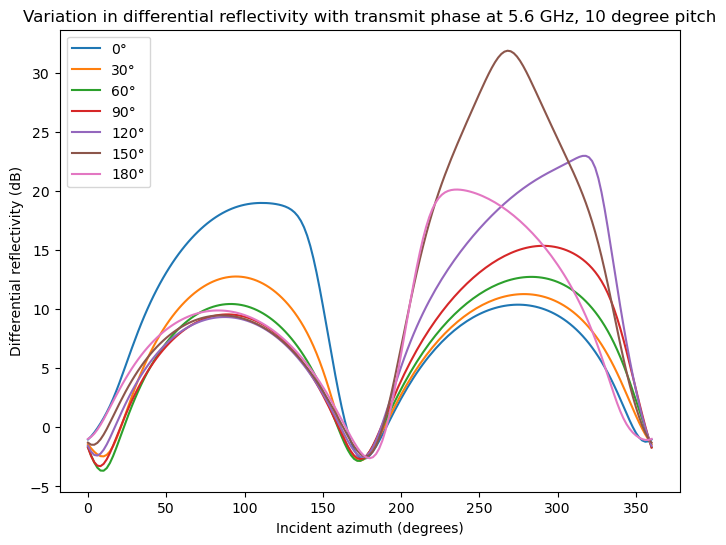

In [11]:
plot_transmit_phase_variation(
    'Differential reflectivity', 
    title='Variation in differential reflectivity with transmit phase at 5.6 GHz, 10 degree pitch', 
    ylabel='Differential reflectivity (dB)'
    )

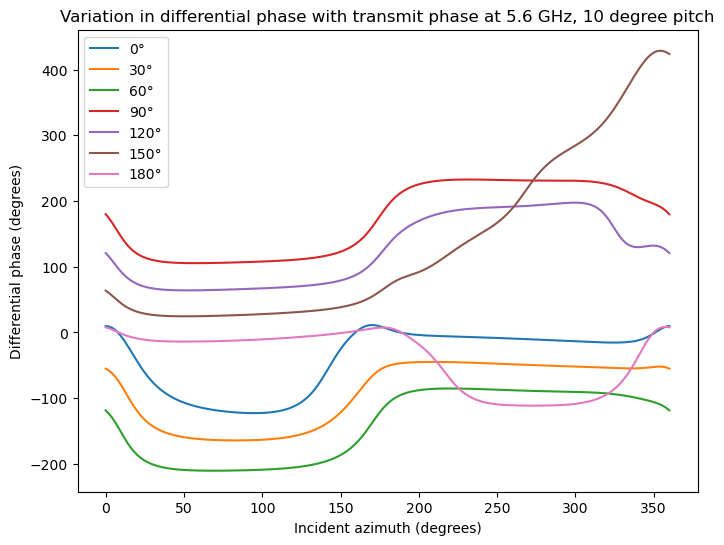

In [12]:
plot_transmit_phase_variation(
    'Differential Phase', 
    title='Variation in differential phase with transmit phase at 5.6 GHz, 10 degree pitch', 
    ylabel='Differential phase (degrees)'
    )

## Figure for poster

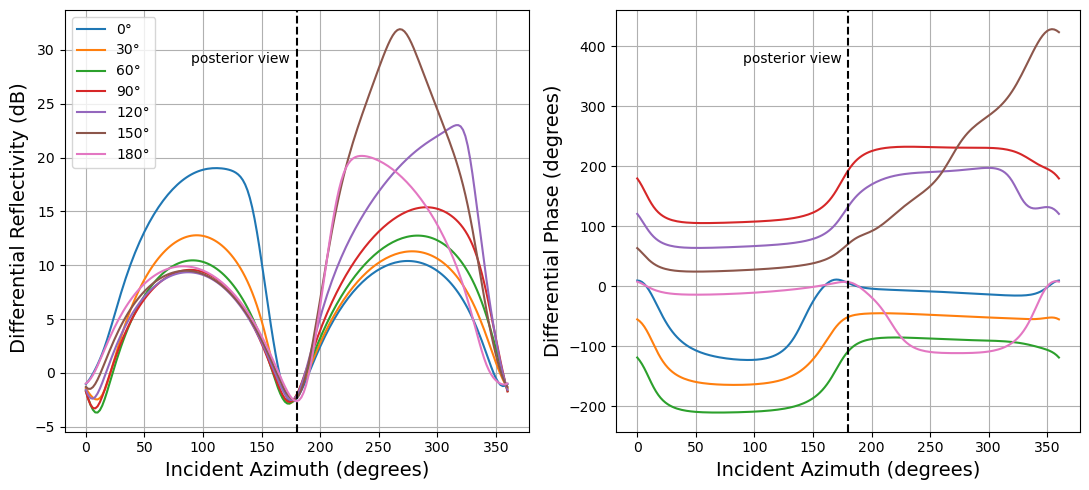

In [28]:
fig, axes = plt.subplots(1,2, figsize=(11,5))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

for counter, phi_T_deg in enumerate(phi_T_list):
    axes[0].plot(H_B['phi'], results_dict['Moth'][phi_T_deg]['Differential reflectivity'], label=f"{phi_T_deg}°")#, color =colors[counter])
    axes[1].plot(H_B['phi'], results_dict['Moth'][phi_T_deg]['Differential Phase'], label=f"{phi_T_deg}°")#, color =colors[counter])

for ax in axes:
    # Draw the vertical line
    ax.axvline(x=180, linestyle='--', color='black')
    
    # Get current y-limits to place text in the middle
    y_min, y_max = ax.get_ylim()
    y_pos = y_max - (y_max - y_min) * 0.1  # 10% below top

    # Add text label near the line
    ax.text(90, y_pos, 'posterior view', rotation=0, va='top', ha='left', color='black')
    ax.grid()

axes[0].legend()
axes[0].set_ylabel(' Differential Reflectivity (dB)', fontsize =14)
axes[0].set_xlabel('Incident Azimuth (degrees)', fontsize =14)
axes[1].set_xlabel('Incident Azimuth (degrees)', fontsize =14)
axes[1].set_ylabel('Differential Phase (degrees)', fontsize =14)


#fig.suptitle('Sensitivity of the dual-polarisation scattering properties to differential phase on transmission with 10 degree pitch',fontsize=13)

fig.tight_layout()

fig.savefig('./AMS_poster_plots/phiT_10_pitch.svg')

# Make axes font bigger, add tail line